# Rankings and Return Levels Summary
```{glue:figure} ranking_and_return_level_summary_fig
:name: "ranking_and_return_level_summary_fig"
:scale: 25%
:align: right
```

In this notebook we'll create a summary-level view of our previous notebooks, by turning what we've created so far into a table and a figure.

## Setup
For this notebook we'll use the Honolulu tide gauge.

In [289]:
%run setup.ipynb
import json
sys.path.append("../python/nonstationaryGEV")
import helpers, models, plotting, imports

base_dir = Path(data_dir).parent
dirs = imports.make_directoryDict(base_dir)

STATION_ID = '1612340'  # Example station ID
# open best_params.json
with open(f'{dirs['model_output_dir']}/{STATION_ID}/best_params.json', 'r') as f:
    best_params = json.load(f)

In [275]:
# open the stationary return levels:
return_period_xr = xr.open_dataarray(output_dir/ 'return_period_stationary_CI.nc')

### Create a dataframe to hold our stationary GEV values

In [276]:
return_period_xr['station_id' == STATION_ID].values
stationary_df = pd.DataFrame({
    'ReturnPeriod': return_period_xr['return period'].values,
    'RLs_stationary': return_period_xr.sel(station_id=STATION_ID, stat='Water Level (m, MHHW)').values,
    'RL_low_stationary': return_period_xr.sel(station_id=STATION_ID, stat='Lower CI (m, MHHW)').values,
    'RL_high_stationary': return_period_xr.sel(station_id=STATION_ID, stat='Upper CI (m, MHHW)').values
})

stationary_df.set_index('ReturnPeriod', inplace=True)
stationary_df

,RLs_stationary,RL_low_stationary,RL_high_stationary
ReturnPeriod,,,
2,0.269739,0.255657,0.318656
5,0.323692,0.308015,0.378581
10,0.353117,0.335700,0.388723
50,0.403954,0.374387,0.438383
100,0.420785,0.382729,0.457974


### Create a dataframe to hold our nonstationary GEV values
First we'll define a function to grab the years we'd like to evaluate in the nonstationary GEV model.

In [277]:
def get_year_RL(best_params, years_list, ReturnPeriod):
    """
    Calculate the return levels for a specific year based on the best parameters.
    """
    years, RL, RL_high, RL_low = helpers.getTimeDependentReturnValue(
        best_params['modelInfo']['t'], 
        best_params['modelInfo']['covariate'], 
        best_params['w'], 
        best_params['x'], 
        ReturnPeriod, 
        best_params['mio']
    )
    year0 = best_params['modelInfo']['year0']
    years = years + year0

    RLs_targets = {}
    RLs_low = {}
    RLs_high = {}
    for year in years_list:
        idx = np.where(years == year)[0]
        if len(idx) == 0:
            RLs_targets[year] = None  # or handle missing year 
            RLs_high[year] = None
            RLs_low[year] = None
        else:
            RLs_targets[year] = RL[:, idx[0]]
            RLs_high[year] = RL_high[:, idx[0]]
            RLs_low[year] = RL_low[:, idx[0]]

    return RLs_targets, RLs_high, RLs_low

In [278]:
years = [2000, 2020]
RLs_nSGEV, RL_high, RL_low = get_year_RL(best_params, years, ReturnPeriod)

df = pd.DataFrame({'ReturnPeriod': ReturnPeriod})

for year in years:
    # RLs_nSGEV[year] is already 1D (length 10)
    df[f'RLs_{year}'] = RLs_nSGEV[year] if RLs_nSGEV[year] is not None else [None]*len(ReturnPeriod)
    df[f'RL_low_{year}'] = RL_low[year] if RL_low[year] is not None else [None]*len(ReturnPeriod)
    df[f'RL_high_{year}'] = RL_high[year] if RL_high[year] is not None else [None]*len(ReturnPeriod)


df.set_index('ReturnPeriod', inplace=True)
NSgev_df = df.copy()

Time-dependent return values calculated


# Combine stationary and nonstationary GEV values

In [279]:
#combine NSgev and stationary
# first make the return period the index of stationary_df


# now make the NSgev in MHHW datum to match nonstationary
NSgev_df_MHHW = NSgev_df  - best_params['modelInfo']['STNDtoMHHW']

combined_df = pd.concat([NSgev_df_MHHW, stationary_df], axis=1)

#### Clean up the dataframe

In [281]:
def str_CI(lowCI, highCI):
    return f"{lowCI:.2f} - {highCI:.2f}"

combined_df['RLs_2000_CI'] = combined_df.apply(lambda row: str_CI(row['RL_low_2000'], row['RL_high_2000']), axis=1)
combined_df['RLs_2020_CI'] = combined_df.apply(lambda row: str_CI(row['RL_low_2020'], row['RL_high_2020']), axis=1)
combined_df['RLs_stationary_CI'] = combined_df.apply(lambda row: str_CI(row['RL_low_stationary'], row['RL_high_stationary']), axis=1)

# make other columns only 2 sig figs
combined_df['RLs_2000'] = combined_df['RLs_2000'].apply(lambda x: f"{x:.2f}")
combined_df['RLs_2020'] = combined_df['RLs_2020'].apply(lambda x: f"{x:.2f}")
combined_df['RLs_stationary'] = combined_df['RLs_stationary'].apply(lambda x: f"{x:.2f}")

In [282]:
combined_df.drop(columns=['RL_low_2000', 'RL_high_2000', 'RL_low_2020', 'RL_high_2020', 'RL_low_stationary', 'RL_high_stationary'], inplace=True)
combined_df

,RLs_2000,RLs_2020,RLs_stationary,RLs_2000_CI,RLs_2020_CI,RLs_stationary_CI
ReturnPeriod,,,,,,
2,0.28,0.40,0.27,0.26 - 0.30,0.39 - 0.42,0.26 - 0.32
5,0.31,0.43,0.32,0.29 - 0.33,0.41 - 0.45,0.31 - 0.38
10,0.33,0.45,0.35,0.31 - 0.35,0.43 - 0.47,0.34 - 0.39
50,0.37,0.49,0.40,0.34 - 0.39,0.46 - 0.51,0.37 - 0.44
100,0.38,0.50,0.42,0.35 - 0.41,0.47 - 0.53,0.38 - 0.46


In [283]:
best_params['x']
param_names = ['Annual seasonal cycle',
    'Semiannual seasonal cycle',
    'Triannual seasonal cycle',
    'Long-term Trend in Location',
    'Covariate in Location',
    'Covariate in Scale',
    'Nodal Cycle']

# Write out the parameter names, where if x[i] = 1, the parameter is included, otherwise it is removed from the list
parameters_included = [param for i, param in zip(best_params['x'], param_names) if i == 1]


# Format the parameter names for display, where each parameter is separated by a comma and the last parameter is preceded by 'and'
parameters_included = ', '.join(parameters_included[:-1]) + ', and ' + parameters_included[-1]
parameters_included

'Annual seasonal cycle, Semiannual seasonal cycle, Long-term Trend in Location, Covariate in Location, and Nodal Cycle'

### Make a Table

In [ ]:
#turn into great table 
# Convert the DataFrame to a great_table
from great_tables import GT, html, md

station_name = best_params['modelInfo']['station_name']
station_id = best_params['modelInfo']['stationID']
nsGEVmodel_string = "The nonstationary GEV model shown here includes the " + parameters_included.lower() + "."

tablename = "SL_return_levels_merge_" + station_name + ".png"
savepath = output_dir / tablename

(
    GT(combined_df.reset_index())
    .tab_header(title='Return Levels Summary', subtitle='Station: '+ station_name + ' (' + str(station_id) + ')')
    .cols_align('center')
    .cols_label(
        ReturnPeriod=html("Return Period (years)"),
        RLs_stationary=html('Return Level'),
        RLs_stationary_CI=html('95% CI'),
        RLs_2000=html('Return Level'),
        RLs_2000_CI=html('95% CI'),
        RLs_2020=html('Return Level'),
        RLs_2020_CI=html('95% CI')
    )
    .tab_spanner(
        label="Stationary GEV",
        columns=["RLs_stationary", "RLs_stationary_CI"]
    )
    .tab_spanner(
        label="Nonstationary: 2000",
        columns=["RLs_2000", "RLs_2000_CI"]
    )
    .tab_spanner(
        label="Nonstationary: 2020",
        columns=["RLs_2020", "RLs_2020_CI"]
    )
    .tab_source_note(source_note='Source: NOAA CO-OPS Hourly Water Level, units in meters relative to MHHW. ' + nsGEVmodel_string)
    .save(savepath, scale = 2, window_size=(2000,2000)) )



GT(_tbl_data=   ReturnPeriod RLs_2000 RLs_2020 RLs_stationary  RLs_2000_CI  RLs_2020_CI  \
0             2     0.28     0.40           0.27  0.26 - 0.30  0.39 - 0.42   
1             5     0.31     0.43           0.32  0.29 - 0.33  0.41 - 0.45   
2            10     0.33     0.45           0.35  0.31 - 0.35  0.43 - 0.47   
3            50     0.37     0.49           0.40  0.34 - 0.39  0.46 - 0.51   
4           100     0.38     0.50           0.42  0.35 - 0.41  0.47 - 0.53   

  RLs_stationary_CI  
0       0.26 - 0.32  
1       0.31 - 0.38  
2       0.34 - 0.39  
3       0.37 - 0.44  
4       0.38 - 0.46  , _body=<great_tables._gt_data.Body object at 0x312cd7d90>, _boxhead=Boxhead([ColInfo(var='ReturnPeriod', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Return Period (years)'), column_align='center', column_width=None), ColInfo(var='RLs_2000', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Return Level'), column_align='center', column_width=None), ColInfo(var='RLs_2000_CI', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='95% CI'), column_align='center', column_width=None), ColInfo(var='RLs_2020', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Return Level'), column_align='center', column_width=None), ColInfo(var='RLs_2020_CI', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='95% CI'), column_align='center', column_width=None), ColInfo(var='RLs_stationary', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Return Level'), column_align='center', column_width=None), ColInfo(var='RLs_stationary_CI', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='95% CI'), column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x312c3b0b0>, _spanners=Spanners([SpannerInfo(spanner_id='Stationary GEV', spanner_level=0, spanner_label='Stationary GEV', spanner_units=None, spanner_pattern=None, vars=['RLs_stationary', 'RLs_stationary_CI'], built=None), SpannerInfo(spanner_id='Nonstationary: 2000', spanner_level=0, spanner_label='Nonstationary: 2000', spanner_units=None, spanner_pattern=None, vars=['RLs_2000', 'RLs_2000_CI'], built=None), SpannerInfo(spanner_id='Nonstationary: 2020', spanner_level=0, spanner_label='Nonstationary: 2020', spanner_units=None, spanner_pattern=None, vars=['RLs_2020', 'RLs_2020_CI'], built=None)]), _heading=Heading(title='Return Levels Summary', subtitle='Station: Honolulu (1612340)', preheader=None), _stubhead=None, _source_notes=['Source: NOAA CO-OPS Hourly Water Level, units in meters relative to MHHW. The nonstationary GEV model shown here includes the annual seasonal cycle, semiannual seasonal cycle, long-term trend in location, covariate in location, and nodal cycle.'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x31d4c6b70>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInf

## Make a plot 
Showing the various return levels and rankings.

In [285]:
# load the rankings csv for the stationID
top10table = output_dir / f"SL_top_10_table_{station_name}.csv"
rankings_df = pd.read_csv(top10table)

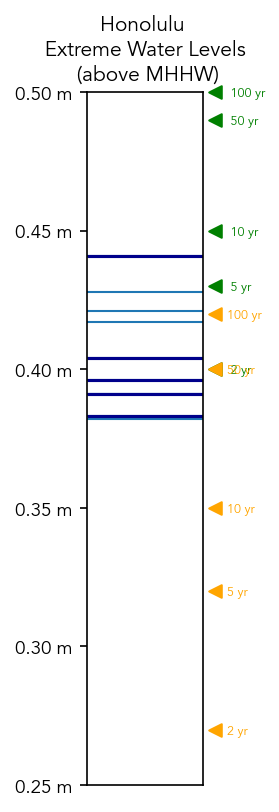

In [288]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1,6))

markers = ['o', 's', '^', 'D', 'v']
xmin,xmax = 0.96, 1.04

dates = pd.to_datetime(rankings_df['Highest Date'])
in_2020 = dates.dt.year == 2020
rankings_2020 = rankings_df[in_2020]

plt.hlines(rankings_df['Highest'], xmin=xmin, xmax=xmax, label='Highest', linewidth=1)
plt.hlines(rankings_2020['Highest'], xmin=xmin, xmax=xmax, color='darkblue')

for idx, (rp, row) in enumerate(combined_df.iterrows()):
    # Draw a horizontal line for each return level at x=1
    plt.scatter(1.1,float(row['RLs_2020']), 
               color='green', label=rp if idx == 0 else "", marker='<',
               transform = ax.get_yaxis_transform(),clip_on=False)
    # Add label on y-axis right side
    ax.text(1.2, float(row['RLs_2020']), " " +str(rp) + " yr",  
            ha='left', color='green', fontsize=6, clip_on=False,
            transform=ax.get_yaxis_transform(),va='center')

    plt.scatter(1.1,float(row['RLs_stationary']), 
               color='orange', label=rp if idx == 0 else "", marker='<',
               transform = ax.get_yaxis_transform(),clip_on=False)
    ax.text(1.2, float(row['RLs_stationary']), str(rp) + " yr ", 
            va='center', ha='left', color='orange', fontsize=6,
            transform=ax.get_yaxis_transform(),clip_on=False)
   # Optionally, plot a marker at x=1 for each return level
    # plt.scatter(1, float(row['RLs_2020']), color='green', marker=markers[idx], label=f"{rp} yr" if idx == 0 else "")

# set ylabel
ax.set_title(f'{station_name} \n Extreme Water Levels \n (above MHHW)', fontsize=10)
# set x-axis limits
plt.xlim(xmin, xmax)
plt.ylim(min(combined_df[['RLs_2020','RLs_stationary']].astype(float).min()), 
         max(combined_df[['RLs_2020','RLs_stationary']].astype(float).max()))

# remove xlabels and ticks
ax.set_xticks([])
ax.set_xticklabels([])

yticks = ax.get_yticks()
ax.set_yticks(yticks)  # Explicitly set the ticks
ax.set_yticklabels([f"{y:.2f} m" for y in yticks])

# save the figure
figname = 'ranking_and_return_level_summary_' + station_name + '.png'
plt.savefig(output_dir / figname, dpi=300, bbox_inches='tight')

glue('ranking_and_return_level_summary_fig', fig,display=False)


```{glue:figure} ranking_and_return_level_summary_fig
:name: "ranking_and_return_level_summary_fig"

Top 10 observed water levels (blue lines) at {glue:text}`station_name`, relative to MHHW. Events occuring during 2020 are shown in darker blue. The heights associated with specific return periods are denoted by the arrows on the right. Orange arrows are calculated using the stationary GEV method (assuming no temporal effects on extreme water levels). Green arrows are the 2020 return levels using the nonstationary GEV model calculated in the nonstationary GEV notebook. 

```

